<a href="https://colab.research.google.com/github/shreyjasuja/cifar_10_custom_resnet/blob/main/dl_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of images in CIFAR10 using ResNet architechture

**Authors :**

*   *Shrey Jasuja : sj4020*
*   *Prasanna Sai Puvvada : pp2689*
*   *Rahul Raj : rr4185*






Link to model weights : https://bit.ly/dl-7123

Addding required imports

In [2]:
import torchvision
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
import json
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np

## Dataset Preparation :

### Image Transformations
Adding image transformations for data augmentation of training data.
Using normalization for both train and test.

In [3]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

### Dataset Loading
Loading custom transformed versions of CIFAR10 from torchvision


In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)


100%|██████████| 170498071/170498071 [00:03<00:00, 48976659.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Splitting the training dataset into a new training and validation dataset based on a validation ratio of 0.9.

In [5]:
# VALID_RATIO = 0.9

# n_train_examples = int(len(trainset) * VALID_RATIO)
# n_valid_examples = len(trainset) - n_train_examples

# trainset,validset = data.random_split(trainset, [n_train_examples, n_valid_examples])

Defining PyTorch dataloaders for the training, validation, and testing datasets.

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# validloader = torch.utils.data.DataLoader(validset.dataset, batch_size=128,
#                                           shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)


Let's have a look at a batch of denormalized data from our dataloader.

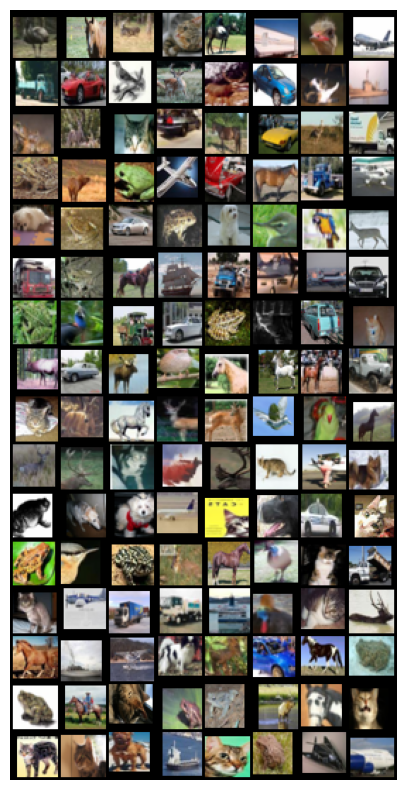

In [7]:
import numpy as np
# Get a batch of images
images, labels = next(iter(trainloader))

# Unnormalize the images
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2023, 0.1994, 0.2010])
images = (images * std.reshape(1,3,1,1)) + mean.reshape(1,3,1,1)

# Visualize the images
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(torchvision.utils.make_grid(images, padding=2, normalize=False), (1,2,0)))
plt.axis('off')
plt.show()


## Model Architecture

### Resnet Block

Our Resnet_block consists of two convolutional layers with batch normalization and ReLU activation, followed by a residual connection that adds the input to the output of the second convolutional layer. 

Whnenused, the residual connection applies a 1x1 convolution and batch normalization with stride=2 to the input tensor to match the output tensor's dimensions.

The output of the block is the ReLU activation of the sum of the residual connection and the output of the second convolutional layer.

In [8]:
class Resnet_block(nn.Module):
  def __init__(self,in_channels,out_channels,stride=1):
    super(Resnet_block,self).__init__()
    self.conv1=nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3,stride=stride,padding=1,bias=False)
    self.bn1= nn.BatchNorm2d(out_channels)
    self.relu1=nn.ReLU()
    
    self.conv2=nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False)
    self.bn2=nn.BatchNorm2d(out_channels)
    self.relu2=nn.ReLU()

    self.residual=nn.Sequential()
    if stride!=1 or in_channels!=out_channels:
      self.residual=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=1, stride=stride, bias=False),
                                  nn.BatchNorm2d(out_channels)
                                  )

  def forward(self,x):
    
    out=self.conv1(x)
    out=self.bn1(out)
    out= self.relu1(out)

    out =self.conv2(out)
    out =self.bn2(out)

    out +=self.residual(x)
    out= self.relu2(out)
    return out

In [9]:
test_image=torch.randn(1,3,32,32)
res_block=Resnet_block(3,3)


In [10]:
y=res_block(test_image)

In [11]:
print(res_block)

Resnet_block(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (residual): Sequential()
)


### Resnet Network

The custom_Resnet class defines a ResNet architecture for image classification tasks consisting of four layers, each containing multiple Resnet_blocks.

The input is passed through a 3x3 convolutional layer with batch normalization and ReLU activation.

The last ResNet layer is followed by global average pooling, dropout, and a fully connected layer with num_classes output neurons.

The architecture is controlled by the n_start_filters and layers arguments, which determine the number of output channels and the number of Resnet_blocks in each layer.

In [12]:
class custom_Resnet(nn.Module):
  def __init__(self,block,n_start_filters,layers,num_classes,dropout_prob=0.5):
    super(custom_Resnet,self).__init__()
    self.in_channels=n_start_filters
    self.layer1=nn.Sequential(
    nn.Conv2d(3,n_start_filters,kernel_size=3,bias=False,padding=1),
    nn.BatchNorm2d(n_start_filters),
    nn.ReLU(inplace=True),
#     nn.Dropout2d(p=0.3)
    )
    self.layer2=self.make_layer(block,n_start_filters,layers[0],stride=1)
    self.layer3=self.make_layer(block,n_start_filters*2,layers[1],stride=2)
    self.layer4=self.make_layer(block,n_start_filters*4,layers[2],stride=2)
    # self.layer4=self.make_layer(block,n_start_filters*8,layers[3],stride=2)
    self.dropout = nn.Dropout(dropout_prob)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(self.in_channels, num_classes)

  
  def make_layer(self,block,out_channels,n_blocks,stride):
    layers=[]
    layers.append(block(self.in_channels,out_channels,stride))
    self.in_channels=out_channels
    layers.extend([block(out_channels,out_channels) for i in range(1,n_blocks)])
    return nn.Sequential(*layers)
    # layers = [layer1, layer2, layer3]
    # model = nn.Sequential(*layers)

  def forward(self, x):
        # out = self.conv1(x)
        # out = self.bn1(out)
        # out = self.relu(out)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

model=custom_Resnet(Resnet_block,32,[13,13,13],10,0.5)

Summary of the final network:

In [13]:
summary(model.cuda(),(3,32,32),1,device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 32, 32]             864
       BatchNorm2d-2            [1, 32, 32, 32]              64
              ReLU-3            [1, 32, 32, 32]               0
            Conv2d-4            [1, 32, 32, 32]           9,216
       BatchNorm2d-5            [1, 32, 32, 32]              64
              ReLU-6            [1, 32, 32, 32]               0
            Conv2d-7            [1, 32, 32, 32]           9,216
       BatchNorm2d-8            [1, 32, 32, 32]              64
              ReLU-9            [1, 32, 32, 32]               0
     Resnet_block-10            [1, 32, 32, 32]               0
           Conv2d-11            [1, 32, 32, 32]           9,216
      BatchNorm2d-12            [1, 32, 32, 32]              64
             ReLU-13            [1, 32, 32, 32]               0
           Conv2d-14            [1, 32,

## Training Setup
Finally, we are going to train our model. We will also be savings our checkpoints using torch.save().

### Weights Initialization:

We are initializing the weights using Kaiming initialization for Convolutional layers and Xavier initialization for Linear layers, both with a ReLU activation function.

In [ ]:
def initialize_parameters(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)



Saving a checkpoint of the model:

### Hyperparameters
We are using SGD as the optimization algorithm, OneCycleLR as the learning rate scheduler, and cross-entropy loss as the loss function for neural network training.





In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,weight_decay=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
max_lr = 0.1  # maximum learning rate
div_factor = 10  # factor to divide the maximum learning rate by
pct_start = 0.3  # percentage of the cycle used for increasing the learning rate

lr_scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=div_factor, 
                       pct_start=pct_start, cycle_momentum=False,steps_per_epoch=400 ,epochs=210)
model = model.to(device)
criterion = criterion.to(device)

Accuracy Calcuation:

In [16]:
def calculate_accuracy(y_pred, y):
    _, predicted = torch.max(y_pred.data, 1)
    correct = (predicted == y).sum().item()
    total = y.size(0)
    acc = 100 * correct / total
    return acc

Defining a training function that trains a neural network model for one epoch on a given data loader using the optimizer and criterion specified. The function calculates the loss and accuracy for each batch in the data loader, backpropagates the loss, and updates the optimizer. The function returns the average loss and accuracy for the entire epoch.

In [ ]:
def train(model, data_loader, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
                
        y_pred= model(inputs)
        
        loss = criterion(y_pred, targets)
        
        
        
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        acc = calculate_accuracy(y_pred, targets)
        
        epoch_loss += loss.item()
        epoch_acc += acc
        
    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

Evaluation Function:
defining an evaluation function that is evaluating the performance of a neural network model on a given data loader using the criterion specified. The function is calculating the loss and accuracy for each batch in the data loader and returning the average loss and accuracy for the entire dataset. The model is being set to evaluation mode and no gradients are being computed during evaluation using the torch.no_grad() context.

In [17]:
def evaluate(model, data_loader, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for batch_idx, (inputs, targets) in enumerate(data_loader):

            inputs = inputs.to(device)
            targets = targets.to(device)

            y_pred = model(inputs)

            loss = criterion(y_pred, targets)

            acc = calculate_accuracy(y_pred, targets)

            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training:
Finally, let's begin training.

In [ ]:
train_metrics=[]
test_metrics=[]
import time
val_acc_total=0
EPOCHS=200

for epoch in range (EPOCHS):
  start_time=time.time()
  train_loss,train_acc=train(model,trainloader,optimizer,criterion,device)
  train_metrics.append([train_loss,train_acc])
  print('Epoch [%d/%d], Training Accuracy: %.2f %%' % (epoch+1, EPOCHS, train_acc))
  print('Epoch [%d/%d], Training Loss: %.4f' % (epoch+1, EPOCHS,train_loss))
  val_loss,val_acc=evaluate(model,testloader,criterion,device)
  test_metrics.append([val_loss,val_acc])
  print('Epoch [%d/%d], Test Accuracy: %.2f %%, Test Loss:  %.2f' % (epoch+1, EPOCHS, val_acc, val_loss))
  if val_acc_total<val_acc:
    val_acc_total=val_acc
    torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()},'mini_proj/reg_13_itr7.ckpt') #saving the checkpoint if model's accuracy is better than earlier val accuracy
    print('saving model!')
  end_time=time.time()
  # test_loss,test_acc=evaluate(model,testloader,criterion,device)
  # print(test_loss,test_acc)
#   lr_scheduler.step()
  elapsed_mins, elapsed_secs=epoch_time(start_time,end_time)
  print(f'Time Elapsed {elapsed_mins}m {elapsed_secs}s ')

Epoch [1/200], Training Accuracy: 21.34 %
Epoch [1/200], Training Loss: 2.3428
Epoch [1/200], Test Accuracy: 30.13 %, Test Loss:  1.79
saving model!
Time Elapsed 0m 29s 
Epoch [2/200], Training Accuracy: 35.31 %
Epoch [2/200], Training Loss: 1.7288
Epoch [2/200], Test Accuracy: 43.79 %, Test Loss:  1.60
saving model!
Time Elapsed 0m 29s 
Epoch [3/200], Training Accuracy: 44.37 %
Epoch [3/200], Training Loss: 1.5083
Epoch [3/200], Test Accuracy: 51.80 %, Test Loss:  1.33
saving model!
Time Elapsed 0m 29s 
Epoch [4/200], Training Accuracy: 52.72 %
Epoch [4/200], Training Loss: 1.3159
Epoch [4/200], Test Accuracy: 56.72 %, Test Loss:  1.22
saving model!
Time Elapsed 0m 29s 
Epoch [5/200], Training Accuracy: 59.31 %
Epoch [5/200], Training Loss: 1.1478
Epoch [5/200], Test Accuracy: 58.38 %, Test Loss:  1.16
saving model!
Time Elapsed 0m 29s 
Epoch [6/200], Training Accuracy: 64.77 %
Epoch [6/200], Training Loss: 1.0099
Epoch [6/200], Test Accuracy: 67.76 %, Test Loss:  0.93
saving model!
T

Epoch [50/200], Test Accuracy: 88.94 %, Test Loss:  0.38
Time Elapsed 0m 28s 
Epoch [51/200], Training Accuracy: 93.18 %
Epoch [51/200], Training Loss: 0.2101
Epoch [51/200], Test Accuracy: 86.94 %, Test Loss:  0.47
Time Elapsed 0m 28s 
Epoch [52/200], Training Accuracy: 93.27 %
Epoch [52/200], Training Loss: 0.2064
Epoch [52/200], Test Accuracy: 89.90 %, Test Loss:  0.35
saving model!
Time Elapsed 0m 29s 
Epoch [53/200], Training Accuracy: 93.29 %
Epoch [53/200], Training Loss: 0.2060
Epoch [53/200], Test Accuracy: 89.22 %, Test Loss:  0.35
Time Elapsed 0m 29s 
Epoch [54/200], Training Accuracy: 93.41 %
Epoch [54/200], Training Loss: 0.2006
Epoch [54/200], Test Accuracy: 87.83 %, Test Loss:  0.43
Time Elapsed 0m 28s 
Epoch [55/200], Training Accuracy: 93.23 %
Epoch [55/200], Training Loss: 0.2062
Epoch [55/200], Test Accuracy: 88.39 %, Test Loss:  0.39
Time Elapsed 0m 29s 
Epoch [56/200], Training Accuracy: 93.39 %
Epoch [56/200], Training Loss: 0.2002
Epoch [56/200], Test Accuracy: 8

Epoch [101/200], Test Accuracy: 88.71 %, Test Loss:  0.43
Time Elapsed 0m 29s 
Epoch [102/200], Training Accuracy: 96.12 %
Epoch [102/200], Training Loss: 0.1179
Epoch [102/200], Test Accuracy: 90.33 %, Test Loss:  0.39
Time Elapsed 0m 29s 
Epoch [103/200], Training Accuracy: 96.26 %
Epoch [103/200], Training Loss: 0.1155
Epoch [103/200], Test Accuracy: 90.18 %, Test Loss:  0.41
Time Elapsed 0m 29s 
Epoch [104/200], Training Accuracy: 96.31 %
Epoch [104/200], Training Loss: 0.1136
Epoch [104/200], Test Accuracy: 90.04 %, Test Loss:  0.41
Time Elapsed 0m 29s 
Epoch [105/200], Training Accuracy: 96.29 %
Epoch [105/200], Training Loss: 0.1132
Epoch [105/200], Test Accuracy: 89.42 %, Test Loss:  0.41
Time Elapsed 0m 29s 
Epoch [106/200], Training Accuracy: 96.31 %
Epoch [106/200], Training Loss: 0.1118
Epoch [106/200], Test Accuracy: 86.72 %, Test Loss:  0.60
Time Elapsed 0m 28s 
Epoch [107/200], Training Accuracy: 96.41 %
Epoch [107/200], Training Loss: 0.1117
Epoch [107/200], Test Accura

Epoch [152/200], Training Accuracy: 98.83 %
Epoch [152/200], Training Loss: 0.0353
Epoch [152/200], Test Accuracy: 92.07 %, Test Loss:  0.37
Time Elapsed 0m 29s 
Epoch [153/200], Training Accuracy: 98.89 %
Epoch [153/200], Training Loss: 0.0345
Epoch [153/200], Test Accuracy: 93.16 %, Test Loss:  0.30
Time Elapsed 0m 28s 
Epoch [154/200], Training Accuracy: 99.00 %
Epoch [154/200], Training Loss: 0.0315
Epoch [154/200], Test Accuracy: 93.07 %, Test Loss:  0.32
Time Elapsed 0m 28s 
Epoch [155/200], Training Accuracy: 99.05 %
Epoch [155/200], Training Loss: 0.0296
Epoch [155/200], Test Accuracy: 92.54 %, Test Loss:  0.34
Time Elapsed 0m 29s 
Epoch [156/200], Training Accuracy: 99.10 %
Epoch [156/200], Training Loss: 0.0279
Epoch [156/200], Test Accuracy: 93.26 %, Test Loss:  0.32
Time Elapsed 0m 29s 
Epoch [157/200], Training Accuracy: 99.18 %
Epoch [157/200], Training Loss: 0.0269
Epoch [157/200], Test Accuracy: 92.36 %, Test Loss:  0.38
Time Elapsed 0m 28s 
Epoch [158/200], Training Ac

Saving train test loss in a JSON:

In [ ]:
import json

# create a list


# open a file in write mode
with open('mini_proj/train_13_itr7.json', 'w') as f:
    # write the list to the file as JSON
    json.dump(train_metrics, f)
with open('mini_proj/test_13_itr7.json', 'w') as f:
    # write the list to the file as JSON
    json.dump(test_metrics, f)

## Visulaizations and Analysis:

Load Saved Model

In [32]:
model=custom_Resnet(Resnet_block,32,[13,13,13],10,0.5) 
ckpt =torch.load('/content/drive/MyDrive/DL HW/min_proj_2/80_layer.ckpt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model.load_state_dict(ckpt['model_state_dict'])
model = model.to(device)

### Train test loss

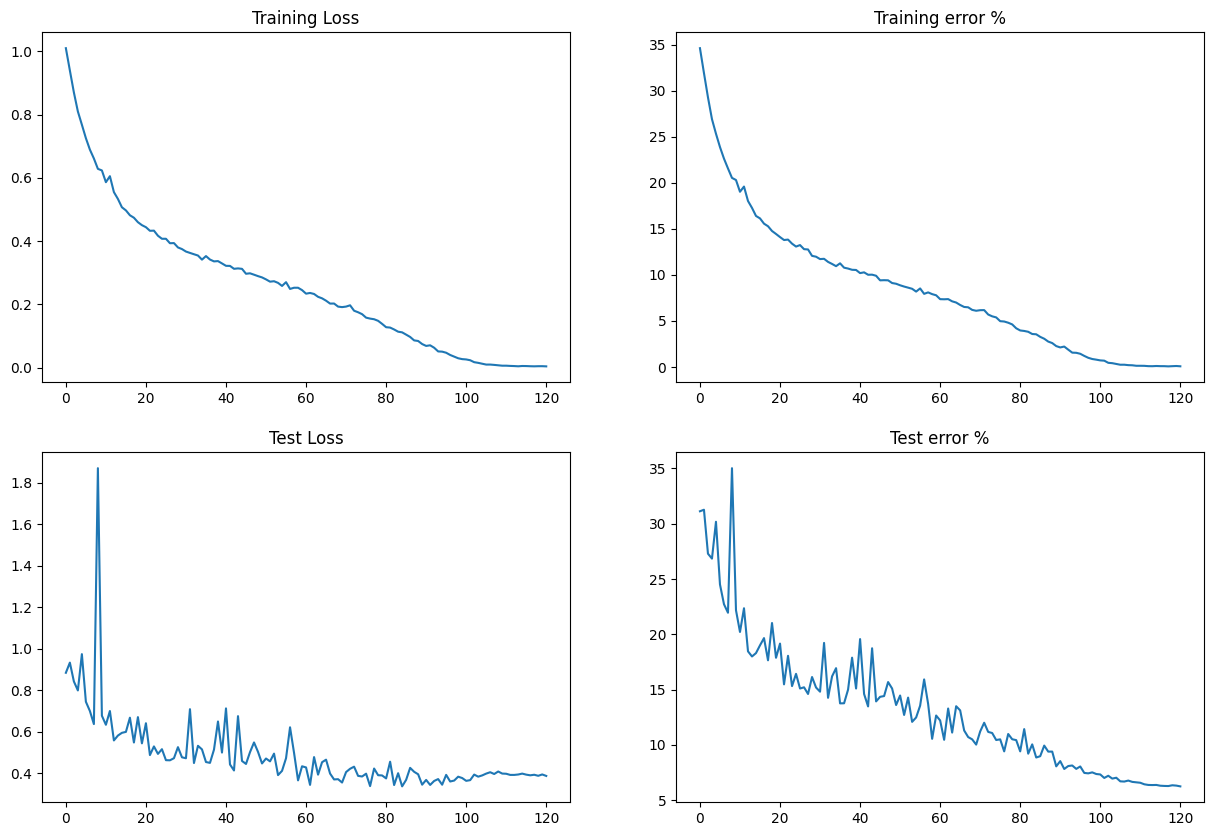

In [33]:
# create empty lists to store the data
train_metrics = []
test_metrics = []
# open a file in read mode and load the JSON data into the appropriate lists
with open('/content/drive/MyDrive/DL HW/min_proj_2/loss_tracks/train_128_layer.json', 'r') as f:
    train_metrics = json.load(f)
with open('/content/drive/MyDrive/DL HW/min_proj_2/loss_tracks/test_128_layer.json', 'r') as f:
    test_metrics = json.load(f)


def plot_metrics(train_metrics,test_metrics):
    fig, axs = plt.subplots(2, 2, figsize=(15,10))
    axs[0, 0].plot([i[0] for i in train_metrics])
    axs[0, 0].set_title('Training Loss')
    axs[0, 1].plot([100-i[1] for i in train_metrics])
    axs[0, 1].set_title('Training error %')
    axs[1, 0].plot([i[0] for i in test_metrics])
    axs[1, 0].set_title('Test Loss')
    axs[1, 1].plot([100-i[1] for i in test_metrics])
    axs[1, 1].set_title('Test error %')

plot_metrics(train_metrics[9:],test_metrics[9:])

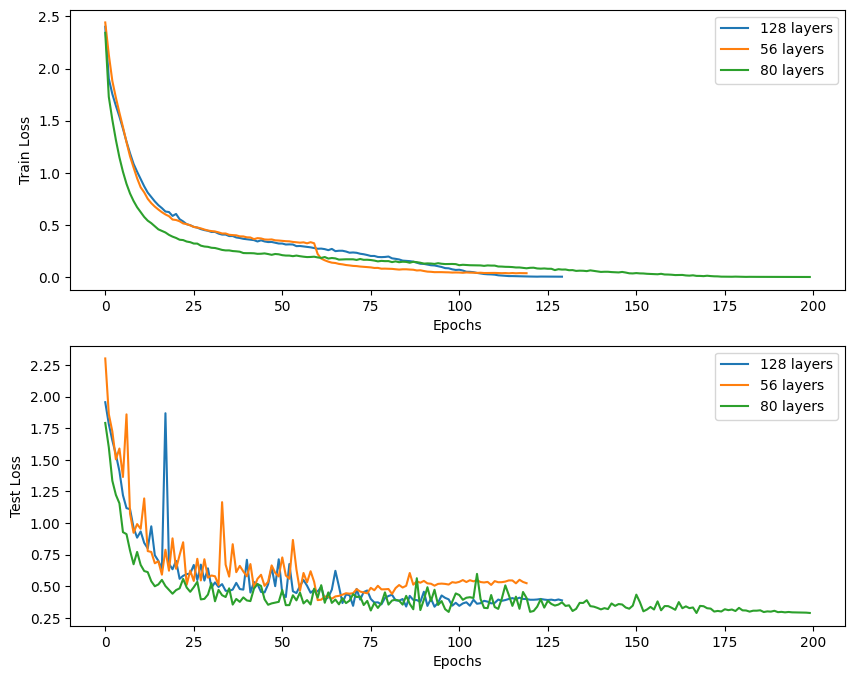

In [ ]:
import json
import matplotlib.pyplot as plt

def load_metrics(file_name):
    with open(file_name, 'r') as f:
        metrics = json.load(f)
    return metrics

# Define the file names
train_files = ['train_128_layer.json', 'train_56_layer.json', 'train_80_layer.json']
test_files = ['test_128_layer.json', 'test_56_layer.json', 'test_80_layer.json']

# Load the JSON data into lists
train_metrics = [load_metrics(file_name) for file_name in train_files]
test_metrics = [load_metrics(file_name) for file_name in test_files]

def plot_metrics(train_metrics, test_metrics):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    for i in range(len(train_metrics)):
        axs[0].plot([j[0] for j in train_metrics[i]], label=f'{[128, 56, 80][i]} layers')
        axs[1].plot([j[0] for j in test_metrics[i]], label=f'{[128, 56, 80][i]} layers')

    axs[0].set_ylabel('Train Loss')
    axs[0].set_xlabel('Epochs')
    axs[1].set_ylabel('Test Loss')
    axs[1].set_xlabel('Epochs')
    for ax in axs:
        ax.legend()

plot_metrics(train_metrics, test_metrics)


Our test loss mostly drops for the first 50-60 epochs but stagnates up until around 150. We decided to train a bit more just to be certain if we had reached the best accuracy, and sure enough we ended up acheiving a better accuracy after 175.

We can notice that the train loss keep dropping quite consistently with increasing epochs as expected.

In [34]:

test_loss,test_acc=evaluate(model,testloader,criterion,device)

In [35]:
print(test_loss,test_acc)

0.29127770860361146 95.16416139240506


##**The final accuracy we achieved as shown above was ~ 95.16: %**

### Predictions


Correct predictions: 


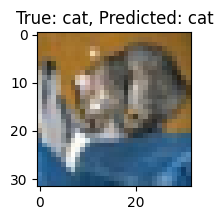

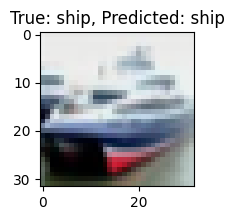

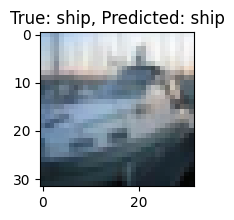

Incorrect predictions: 


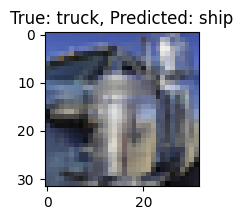

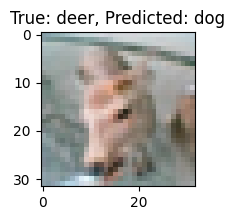

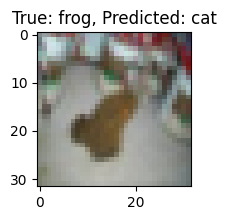

In [27]:
label_map = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

def imshow(img, title):
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = (img * std.reshape(3, 1, 1)) + mean.reshape(3, 1, 1)
    npimg = img.numpy()
    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    
    label, predicted = title.split(', ')
    label = int(label.split(': ')[1])
    predicted = int(predicted.split(': ')[1])
    
    true_class_name = label_map[label]
    predicted_class_name = label_map[predicted]
    
    plt.title(f"True: {true_class_name}, Predicted: {predicted_class_name}")
    plt.show()

def visualize_predictions(model, data_loader, num_samples=5, device='cuda'):
    model.eval()
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
    
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    correct = (predicted == labels).squeeze()
    
    correct_indices = np.where(correct)[0]
    incorrect_indices = np.where(~correct)[0]
    
    print("Correct predictions: ")
    for i in range(num_samples):
      if i < len(correct_indices):
        index = correct_indices[i]
        imshow(images[index], f"True: {labels[index]}, Predicted: {predicted[index]}")

    print("Incorrect predictions: ")    
    for i in range(num_samples):
      if i < len(incorrect_indices):
        index = incorrect_indices[i]
        imshow(images[index], f"True: {labels[index]}, Predicted: {predicted[index]}")

visualize_predictions(model, testloader, num_samples=3, device=device)


Based on our observations, our classifier shows a high accuracy on "distinctive" images, however, it struggles to accurately classify "close-call" images. 

For instance, the deer appears similar to a dog and the frog's image is at an awkward angle, posing a challenge for the model to accurately identify the object. To improve the model's performance on these types of images, it may be beneficial to train it on larger datasets or increase the model's depth, among other possible methods.

In [22]:
def get_predictions(model, iterator, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()#model in eavl_mode

    labels = []
    probs = []

    with torch.no_grad():
        
         for batch_idx, (inputs, targets) in enumerate(iterator):

            inputs = inputs.to(device)
            targets = targets.to(device)

            y_pred = model(inputs)

            loss = criterion(y_pred, targets)

            acc = calculate_accuracy(y_pred, targets)

            epoch_loss += loss.item()
            epoch_acc += acc

            labels.append(targets)#actual_labels
            probs.append(y_pred)#predicted_labels

   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    print(epoch_loss / len(iterator), epoch_acc / len(iterator))#test_loss and test_accuracy
    return labels, probs

In [29]:
labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)

0.29127770860361146 95.16416139240506


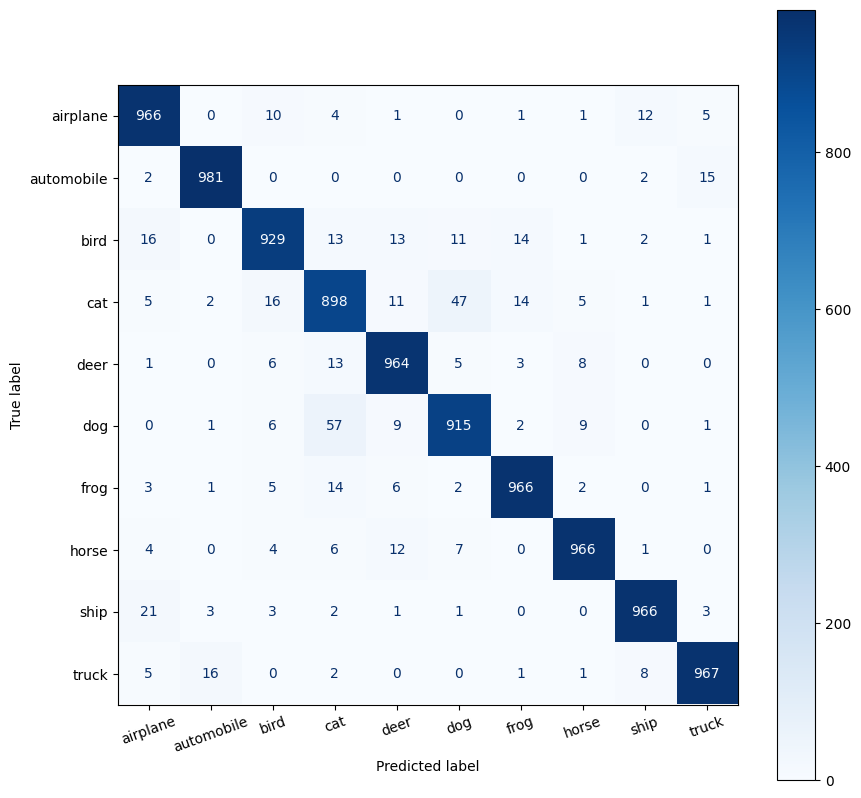

In [31]:
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
plot_confusion_matrix(labels.cpu().numpy(), pred_labels.cpu().numpy(), list(label_map.values())) #plot for confusion matrix